In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from collections import Counter
# svg output in plots
import numpy as np
import tqdm as tqdm
from itertools import chain
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

### Parameters

In [28]:
# Load data
df = pd.read_pickle(r"../Dataset/dataframe.pkl")
df = df[df["Time"] > 1980]

df_i = df.explode("Simplices").reset_index()
all_authors = df_i["Simplices"].unique()
N_a = len(all_authors)
print("Number of authors:", N_a)

Number of authors: 1153729


In [29]:
### Initial condition age distribution

df_all = pd.read_pickle(r"../Dataset/dataframe.pkl")
df_all = df_all.explode("Simplices").reset_index()
all_ini = df_all.groupby("Simplices").min("Time").reset_index()

all_ini["Age"] = 1980 -  all_ini["Time"]

In [30]:
def dist_order(order):
    lam = 4
    Pois = np.exp(-lam)*lam**(order)/np.math.factorial(order)
    return Pois

In [40]:
t0 = 1950
tf = 2021

# Not all authors at the reservoir
N_a = 100
authors = np.array(all_authors[0:N_a])

# Parameters
N = 25 # Maximum number of orders
r = 3000 #(np.log(10**5 - 10**3))/60 # simplices x year
N_simplices = 1000 # Number of simplices at t0

# Memory matrix
M = np.ones((N_a,N_a)) - np.identity(N_a)

ti = t0

simplices = []
time = []

w_t = 0
print("Model starts running")
while ti < tf:
    # Compute total rate:
    W = (r+1)
    
    # Compute next event time
    At = - np.log(np.random.rand())/W
    
    # Time goes on
    ti = ti + At
    w_t = w_t + At

    # Choose main author according to the age
    possible_authors = range(N_a)
    i_a = np.random.randint(0,len(possible_authors))

    o_i = np.random.choice(range(N),p=[dist_order(order) for order in range(N)]/np.sum([dist_order(order) for order in range(N)]))
    if o_i > 0:
        possible_collaborators_index = range(N_a)
        # random choice with preferential attachment from authors to select the collaborators
        if np.sum(M[i_a,:]) > 0:
            i_c = np.random.choice(possible_collaborators_index,size=o_i,replace=False,p=M[i_a,possible_collaborators_index]/np.sum(M[i_a,possible_collaborators_index]))
        else:
            i_c = np.random.choice(possible_collaborators_index,size=o_i,replace=False)
        collaborators = [authors[i] for i in i_c]
        # We update the memory matrix with the new collaboration
        for i in i_c:
            M[i_a,i] = M[i_a,i] + 2
            M[i,i_a] = M[i,i_a] + 2
            for j in i_c:
                M[i,j] = M[i,j] + 2
                M[j,i] = M[j,i] + 2
                M[j,j] = 0
            M[i,i] = 0
        if o_i > 5:
            simplices.append([authors[i_a]] + collaborators)
            time.append(ti)
    if w_t > 1:
        N_simplices = len(simplices)
        print(ti,N_simplices)
        w_t = 0

Model starts running
1951.000394316372 678
1952.0008200276422 1331
1953.0009177813306 1975
1954.0011599264792 2612
1955.0015159004988 3246
1956.0024520718082 3892
1957.0025418367889 4534
1958.0026167548467 5146
1959.0026310652831 5766
1960.002718475839 6393
1961.003051455299 7070
1962.0035856753168 7739
1963.003982533314 8408
1964.0040692432071 9087
1965.0045232319587 9707
1966.0054246900766 10339
1967.006163190174 10969
1968.0065174651804 11574


KeyboardInterrupt: 

In [37]:
df = pd.DataFrame({"Time":time,"Simplices":simplices})

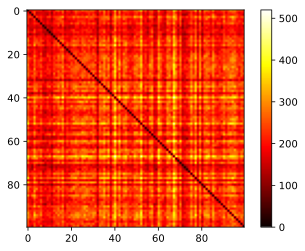

In [43]:
plt.imshow(M, cmap='hot')
plt.colorbar()

In [38]:
df.to_pickle("./Outcomes/Minimalminimal_model.pkl")